<a href="https://colab.research.google.com/github/davidislip/SVM-and-MVO/blob/main/ADM_Comparison_NoteBook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integration of SVM and MVO 

A previous notebook attempted computational experiments with the following MIP formulation. 
$$
\begin{align} 
\min_{x, z, w, b} \quad & x^{\intercal}\Sigma x + \frac{1}{2}||{w}||^2 + \sum_{i=1}^N g(\xi_i)&\\ 
\textrm{s.t.} \quad & \mu^\intercal x  \geq \bar{R}, \quad \sum_i z_i \leq N \\
\quad & z_i \leq M x_i &\forall i = 1,2,...,N  \\
\quad & x_i \leq z_i \quad &\forall i = 1,2,...,N \\
              \quad & y_i^{\intercal} w + b \leq M z_i - \epsilon + \xi_i \quad & \forall i = 1,2,...,N \\
              \quad & -M(1-z_i) + \epsilon - \xi_i \leq  y_i^{\intercal} w + b \quad &\forall i = 1,2,...,N \\
              \quad & x \in \mathcal{C} \quad z \in \{0,1\}^N  \quad  w \in \mathbb{R}^m \quad \xi \geq 0& \\
\end{align} 
$$

with g as $C \xi/N$ where $C$ is a hyperparameter. It was found that directly solving the MIP above proved too computationally expensive. It would take over 24 hours to perform the ~20 years of monthly rebalancing experiments. The length of time required for a single MIP solve was also sensitive to the value of $m$. To address the computational expensiveness of solving the MIP in a  brute force fashion, I propose a penalized alternating direction method. 


## General Alternating Direction Methods 

####The description below is adapted primarily from "An Alternating Method for Cardinality-Constrained..." by Costa et. al. 

Consider the following problem:

$$
\begin{align} 
\min_{u, v} \quad & f(u, v)&\\ 
\textrm{s.t.} \quad & g(u,v) = 0, \quad h(u, v) \geq 0 \\
\quad & u \in \mathcal{U} \subseteq \mathbb{R}^{n_u}, \quad v \in \mathcal{V}  \subseteq \mathbb{R}^{n_v} \\
\end{align} 
$$

A standard alternating direction method (ADM) does the following:

1. Choose initial value $(u^0, v^0) \in \mathcal{U} \times \mathcal{V}$ and $l=0$
2. While not converged 

  2.1 Compute $u^{l+1} \in \text{argmin}\ \{  f(u,v^l): g(u, v^l) = 0, h(u,v^l) \geq 0, u \in \mathcal{U} \ \}$

  2.2 Compute $v^{l+1} \in \text{argmin}\ \{  f(u^{l+1},v): g(u^{l+1}, v) = 0, h(u^{l+1},v) \geq 0, v \in \mathcal{V} \ \}$

  2.3 $l \leftarrow l + 1$

Costa et al. then propose the use of a penalty function - variant of the ADM, whereby the coupling constraints induced by $h$ and $g$ are penalized in the objective as follows:

$$
\phi(u,v; \mu,  \rho) = f(u,v) + \sum_i \mu_i |g_i(u,v)| + \sum_j \rho_i [h_i(u,v)]^-
$$

where $\rho $ and $\mu$ denote the penalty parameters of the equality and inequality constraints. The penalized alternating direction method algorithm is nearly identical to the ADM; however, if the constraints are not satisfied at the end of the iterations, then the penalty parameters are increased, and the iteration is restarted. 

In the case of integrating support vector machines and mean-variance optimization, one formulation is as follows:

$$
\begin{align} 
\min_{x, z, w, b} \quad & x^{\intercal}\Sigma x + \frac{1}{2}||{w}||^2 &\\ 
\textrm{s.t.} \quad & \mu^\intercal x  \geq \bar{R}, \quad \sum_{i} z_i \leq N_l\\
\quad & z_i \leq M x_i &\forall i = 1,2,...,N  \\
\quad & x_i \leq z_i \quad &\forall i = 1,2,...,N \\
              \quad & y_i^{\intercal} w + b \leq M z_i - \epsilon \quad & \forall i = 1,2,...,N  \ (A)\\
              \quad & -M(1-z_i) + \epsilon \leq  y_i^{\intercal} w + b \quad &\forall i = 1,2,...,N\  (B)\\
              \quad & x \in \mathcal{C} \quad z \in \{0,1\}^N & \\
\end{align} 
$$
However, both constraints A and B can be replaced by the non-linear complementary constraint formulation:

$$(2 z_i - 1)(y_i^{\intercal} w + b) \geq 1 \quad i = 1,2,...,N$$

Although the constraint above is non-linear and non-convex, it decomposes into a simple linear constraint for each sub-problem when applying the alternating direction method.


Setting $u = (x, z)$ and $v = (w, b)$, the nominal problem becomes minimizing  $ f(u,v) = x^{\intercal} \Sigma x + \frac{1}{2} ||w||^2$ with 

$\mathcal{U} = \{(x,z) \in \mathbb{R}^N \times \{0,1\}^N \ | \ \mu^{\intercal} x \geq R,\  \mathbf{1}^{\intercal}x = 1,\  z_i= 1 \iff x_i > 0,\  \mathbf{1}^{\intercal} z \leq N_L \}$ 

and

 $\mathcal{V} = \{(w,b) \in \mathbb{R}^{m+1} \}$

and lastly, $h_i(u,v) = (2 z_i - 1)(y_i^{\intercal} w + b) - 1$. Introducing the slack variables $\xi_i \geq 0 $ into the complementary constraint

$$(2 z_i - 1)(y_i^{\intercal} w + b) \geq 1 - \xi_i \quad i = 1,2,...,N$$

implies $[h_i(u,v)]^- = \xi_i(x, z, w, b)$ and that the penalty objective $\phi = x^{\intercal} \Sigma x + \frac{1}{2} ||w||^2 + \sum_{i} \mu_i \xi_i$ 

## Implementation ⌨

Given the previous iteration's SVM sub-problem results: ($w^l$, $b^l$), to obtain $x^{l+1}, z^{l+1}$ one solves $\min_{x, z}\ \{ x^{\intercal} \Sigma x  + \sum_{i} \mu_i \xi_i : \ \xi_i \geq 1 - (2z_i - 1)(y^{\intercal}w^{l} + b^l),\  (x, z) \in \mathcal{U} \ \}$

After computing $x^{l+1}, z^{l+1}$  it follows that $w^{l+1}, b^{l+1}$ are computed by solving $\min_{w, b}\ \{ \frac{1}{2} || w||^2 +  \sum_{i} \mu_i \xi_i : \ \xi_i \geq 1 - (2z^{l+1}_i - 1)(y^{\intercal}w + b),\  (w, b) \in \mathcal{V} \ \}$

In the implementation in this notebook, $\mu_i = C/N$ for a "large" C and the outer loop of incrementally increasing $\mu_i$ is not included. This is because it is possible that for a given return constraint, there may exist no portfolios with a support vector that linearly separates the assets. Therefore a significant preference for linearly separable portfolios should suffice. Furthermore, the two subproblems defined above avoid big M constraints, and are optimized more simply than the full formulation.

## Results from this notebook ⚡

* ADM method solves the min variance integrated SVM problem in approx 2.5 seconds, whereas the exact branch and bound MIP solver takes approx. 240 seconds for N = 286 assets and m = 3 factors used for the SVM decision boundary.
* The two solution methods have a max difference between the resulting portfolios of approximately 3%
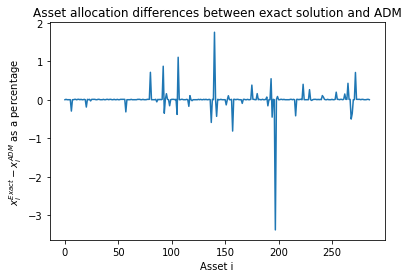

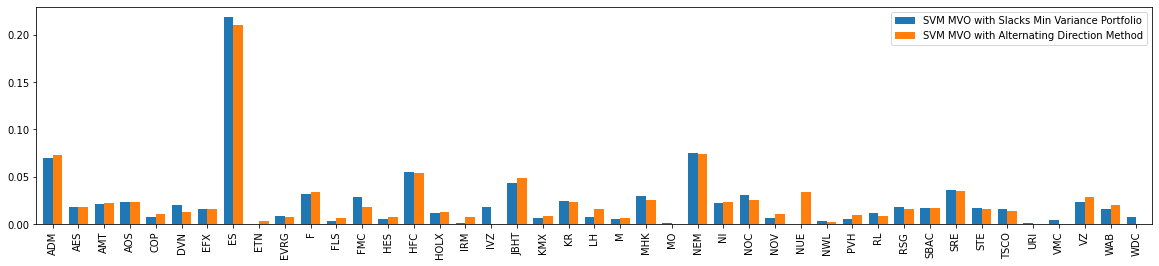
* The in sample mean-variance frontiers for the two methods are nearly identical, as evidenced by the frontier comparison figure
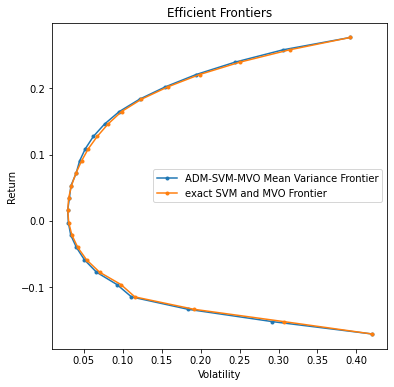


In [11]:
!sudo python -m pip install gurobipy==9.1.2
import gurobipy as gp
from gurobipy import GRB
from google.colab import drive 
import math
import time
drive.mount('/content/gdrive')
pth = 'gdrive/My Drive/Colab Notebooks/'
import sys
sys.path.append(pth + 'SVM MVO/PYFILES/')
from packages import *
#from svm_mvo import *
%matplotlib inline

## Import Forecasts
forecasts = pd.read_pickle(pth +'SVM MVO/DATA/Forecasts.pkl')
## Import Returns
rets = pd.read_pickle(pth + 'SVM MVO/DATA/RETS.pkl')
## Import feature vectors
wrds_svm = pd.read_pickle(pth + 'SVM MVO/DATA/WRDS_ASOF.pkl')
wrds_svm_pca = pd.read_pickle(pth + 'SVM MVO/DATA/WRDS_PCA.pkl')
wrds_svm_pca['Momentum'] = wrds_svm.Momentum
## Import Monthly Prices
prices = pd.read_pickle(pth + 'SVM MVO/DATA/PRICES.pkl')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [12]:
try:
  e = gp.Env(empty=True)
  #e.setParam('OutputFlag', 0)
  gurobi_licence = pd.read_csv(pth +'SVM MVO/DATA/gurobi.csv')
  e.setParam('WLSACCESSID', gurobi_licence.WLSACCESSID[0])
  e.setParam('LICENSEID', gurobi_licence.LICENSEID[0])
  e.setParam('WLSSECRET', gurobi_licence.WLSSECRET[0])
  e.start()
except: 
  !chmod 755 /content/gdrive/My\ Drive/Colab\ Notebooks/SVM\ MVO/gurobi/grbgetkey
  !/content/gdrive/My\ Drive/Colab\ Notebooks/SVM\ MVO/gurobi/grbgetkey 2d15bcec-464e-11ec-8a74-0242ac120003
  e = gp.Env(empty=True)
  #chmod 755 grbgetkey
  e.start()

Changed value of parameter WLSACCESSID
Changed value of parameter LICENSEID
Changed value of parameter WLSSECRET
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Using license file /usr/local/lib/python3.7/dist-packages/gurobipy/.libs/gurobi.lic
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID


In [32]:
%run /content/gdrive/My\ Drive/Colab\ Notebooks/SVM\ MVO/PYFILES/svm_mvo.py

Changed value of parameter WLSACCESSID
Changed value of parameter LICENSEID
Changed value of parameter WLSSECRET
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Using license file /usr/local/lib/python3.7/dist-packages/gurobipy/.libs/gurobi.lic
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID


<Figure size 432x288 with 0 Axes>

In [14]:
mth = rets.index[0]
mth
wrds_svm_pca

0         1         2  ...         5         6  Momentum
MonthStart tic                                 ...                              
2000-07-01 AAPL -0.373278 -1.036200 -0.081772  ...  0.349579  0.471735  0.022558
           ABC   1.021967  0.256179 -1.040983  ...  0.616849 -0.046695  0.190470
           ABMD  1.201335 -0.449091 -0.238241  ...  0.317774  0.342995 -0.034639
           ABT  -1.113849 -0.709214 -0.807198  ... -0.314460  0.438028  0.059950
           ADBE -1.859370 -1.500111 -0.564404  ...  0.386917  0.391264  0.125271
...                   ...       ...       ...  ...       ...       ...       ...
2020-10-01 XOM  -0.050895  1.099566  0.296506  ...  0.836012 -0.299347 -0.062100
           XRAY -0.286820  0.542438  0.078353  ...  0.152256 -0.409161  0.001423
           XRX   0.199412  1.108638 -0.148833  ...  0.845910 -0.314901  0.016172
           YUM  -0.864787 -0.222001 -0.530587  ... -0.620762 -0.252945  0.006949
           ZBRA -0.411947 -0.541825 -0.832081  ... -0.544825 -0.450392  0.007567

[69784 rows x 8 columns]

In [15]:
#convenient function
sign = lambda a: int((a>0)) - int((a<0))

#preprocessing 
cov_, mean_ = forecasts[mth]
N = len(mean_)
cov = cov_[:N,:N] 
mean = mean_[:N,:]
tics = list(rets.columns[:N])
print("valid tickers:", tics)

#get the wharton research data for the valid tickers for the month
wrds_tics = wrds_svm_pca[wrds_svm_pca.index.get_level_values('tic').isin(tics)].xs(mth, level="MonthStart")
Y = wrds_tics.iloc[:,:2] # Y matrix in formulation 
Y['Momentum'] = wrds_tics.Momentum
#restrict the wharton research data to the columns of interest
Y_ =  (Y - Y.mean(axis=0))/(Y.std(axis=0)) #scale the features 
cols = Y.columns.tolist() #use all the columns for this formulation
AssetLim = math.floor(N/1.5)
ret_constr = -1
soft_margin = 2000

valid tickers: ['AAPL', 'ABC', 'ABMD', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AJG', 'AKAM', 'ALB', 'ALK', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMT', 'AMZN', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'ATO', 'AVY', 'AZO', 'BA', 'BAX', 'BBY', 'BDX', 'BKNG', 'BLL', 'BMY', 'BSX', 'BWA', 'CAG', 'CAH', 'CAT', 'CCI', 'CCL', 'CDNS', 'CERN', 'CHD', 'CHRW', 'CI', 'CL', 'CLX', 'CMCSA', 'CMI', 'CMS', 'CNP', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'CTXS', 'CVS', 'CVX', 'D', 'DD', 'DGX', 'DHR', 'DIS', 'DISH', 'DLTR', 'DOV', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXC', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'ES', 'ETN', 'ETR', 'EVRG', 'EXC', 'EXPD', 'F', 'FAST', 'FCX', 'FDX', 'FE', 'FFIV', 'FISV', 'FLS', 'FMC', 'GD', 'GIS', 'GLW', 'GPC', 'GPS', 'GWW', 'HAL', 'HAS', 'HD', 'HES', 'HFC', 'HOG', 'HOLX', 'HON', 'HP', 'HPQ', 'HRB', 'HRL', 'HSIC', 'HSY', 'HUM', 'IBM', 'IDXX', 'IEX', 'IFF', 'INCY', 'INTC', 'INTU', 'IP', 'IPG', 'IRM', 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


## Model Class Definitions




### SVM and MVO Subproblem Class Definitions

In [16]:

class MVO:
 
  # This class models the mean variance subproblem in the ADM method

  bigM = 100
  epsilon = 0.001
  def __init__(self, tics, mean_ret, cov, ret_constr, exogenous, AssetLim, \
               soft_margin = 0, svm_w = None, svm_b = None, svm_xi = None, perspective = False):
    self.tics = tics #list of tickers
    self.mean_ret = mean_ret
    self.cov = cov
    self.ret_constr = ret_constr
    self.AssetLim = AssetLim
    self.exogenous = exogenous # matrix of features for the tickers
    N, m = self.exogenous.shape

    self.model = gp.Model(env = e)
    self.x = self.model.addMVar(N)
    self.z = self.model.addMVar(N, vtype=GRB.BINARY)
    self.v = self.model.addMVar(N, lb = np.zeros(N))
    self.q = self.model.addMVar(N)
    self.xi = self.model.addMVar(N, lb = np.zeros(N))
    self.ret_target = self.model.addConstr(self.port_exptd_ret >= self.ret_constr, 'target')

    self.svm_w = svm_w
    self.svm_b = svm_b
    self.soft_margin = soft_margin
    self.perspective = perspective

    self.model.update()
    
    self.abs = self.model.addMVar(N)

    min_eig = min(np.linalg.eigvals(self.cov)) - 10**(-8)
    self.posdef_diag = np.diag(np.ones(N))*min_eig

  @property
  def portfolio_risk(self):
    return self.x @ self.cov @ self.x
  @property
  def port_exptd_ret(self):
    return self.mean_ret[:,0] @ self.x

  @property
  def soft_penalty(self):
    N, m = self.exogenous.shape
    return (self.soft_margin/N)*self.xi.sum()

  @property
  def portfolio_risk_p(self):
    N, m = self.exogenous.shape
    min_eig = np.min(np.linalg.eigvals(self.cov)) - 10**(-8)
    if min_eig < 0:
      raise ValueError('Negative eigenvalues')
    return self.v.sum() + self.q @ (self.cov - self.posdef_diag) @self.q

  
  def print_var_info(self, names = {}):
    #dictionary of variables and thier names
    for key in names.keys():
      print(key, names[key])
    print("x", self.x.X)
    print("z", self.z.X)
    print("")

  def setModel(self, set_return = True, constrs = []):
    #parameter definitions
    self.model.remove(self.model.getConstrs())
    N, m = self.exogenous.shape
    bigM = MVO.bigM
    epsilon = MVO.epsilon
    #objective function components
    if set_return:
       #remove constraints and reset the return constraints
      self.ret_target = self.model.addConstr(self.port_exptd_ret >= self.ret_constr, 'target')
    if constrs != []:
      for con in constrs:
        self.model.addConstr(con, 'target')

    self.model.update()
    self.model.addConstr(self.x.sum() == 1, 'budget')
    self.model.addConstr(self.z.sum() <= self.AssetLim, 'Cardinality')
    z_ = self.z.tolist()
    x_ = self.x.tolist()
    xi_ = self.xi.tolist()
    self.model.addConstr(self.x <= self.z)
    self.model.setObjective(self.portfolio_risk + self.soft_penalty, GRB.MINIMIZE)

    for i in range(N):
      self.model.addGenConstrIndicator(z_[i], True, x_[i] >= epsilon/(bigM))
      #self.model.addGenConstrIndicator(z_[i], False, x_[i] <= epsilon/(100*bigM) - 10**(-7))
    
    #the SVM info must be uninitialized on the first run
    if type(self.svm_w) is np.ndarray:
      for i in range(N):
        y_i = self.exogenous.iloc[i].values
        a = np.dot(y_i, self.svm_w) + self.svm_b 
        self.model.addConstr(2*a[0]*z_[i] >= a[0] + epsilon - xi_[i], 'svm'+str(i))

  def optimize(self,cbb = None):

    if cbb not in [None]:
      self.model._cur_obj = float('inf')
      self.model._time = time.time()
      self.model.optimize(callback = cbb)
    else:
      self.model.optimize()
    self.model.write('portfolio_selection_optimization.lp')

  def evaluate(self, realized_ret):

    ret = np.dot(self.x.X, realized_ret)
    return ret #use this to calculate out of sample rets and var

  def get_estimates(self):

    vol_metric = np.sqrt(self.portfolio_risk.getValue())[0]
    expt_ret_metric = self.port_exptd_ret.getValue()[0]
    return [vol_metric, expt_ret_metric] #use this for efficient frontiers


class SVM:

# This class models the support vector machine subproblem in the ADM method

  bigM = 100
  epsilon = 0.001
  def __init__(self, tics, exogenous, soft_margin, mvo_z = None):
    self.tics = tics #list of tickers
    self.exogenous = exogenous # matrix of features for the tickers
    self.soft_margin = soft_margin #hyper parameter

    N, m = self.exogenous.shape

    self.model = gp.Model(env = e)
    self.w = self.model.addMVar(m)
    self.b = self.model.addMVar(1)
    self.xi = self.model.addMVar(N, lb = np.zeros(N))

    self.mvo_z = mvo_z


    self.abs = self.model.addMVar(N)


  @property
  def soft_penalty(self):
    N, m = self.exogenous.shape
    return (self.soft_margin/N)*self.xi.sum()
  @property
  def svm_margin(self):  
    return (1/2)*(self.w @ self.w)  

  def print_var_info(self, names = {}):
    #dictionary of variables and thier names
    for key in names.keys():
      print(key, names[key])
    print("x", self.w.X)
    print("z", self.b.X)
    print("xi", self.xi.X)
    print("")

  def setModel(self):
    #remove constraints
    self.model.remove(self.model.getConstrs())
    #parameter definitions
    N, m = self.exogenous.shape
    bigM = SVM.bigM
    epsilon = SVM.epsilon
    #objective function components


    w_ = self.w.tolist()
    b_ = self.b.tolist()
    xi_ = self.xi.tolist()
    self.model.setObjective(self.svm_margin + self.soft_penalty, GRB.MINIMIZE)

    for i in range(N):
      y_i = self.exogenous.iloc[i].values
      self.model.addConstr((2*self.mvo_z[i] - 1)*(y_i @ self.w + self.b) >= epsilon - self.xi[i])

  def optimize(self,cbb = None):

    if cbb not in [None]:
      self.model._cur_obj = float('inf')
      self.model._time = time.time()
      self.model.optimize(callback = cbb)
    else:
      self.model.optimize()
    self.model.write('portfolio_selection_optimization.lp')

  def evaluate(self, realized_ret):

    ret = np.dot(self.x.X, realized_ret)
    return ret #use this to calculate out of sample rets and var

  def get_estimates(self):

    vol_metric = np.sqrt(self.portfolio_risk.getValue())[0]
    expt_ret_metric = self.port_exptd_ret.getValue()[0]
    return [vol_metric, expt_ret_metric] #use this for efficient frontiers

   


### Mean Variance and SVM Joint Using Alternating Directions Method Class Deinition

In [17]:
MVO_ = MVO(tics, mean, cov, ret_constr, Y_, AssetLim)
SVM_ = SVM(tics, Y_ , soft_margin)

class SVM_MVO_ADM:
  # '''this class models the integrated SVM MVO problem using the ADM solution method'''
  bigM = 100
  epsilon = 0.001
  def __init__(self, MVO_, SVM_, IterLim = 200):
    self.MVO_ = MVO_
    self.SVM_ = SVM_
    self.IterLim = IterLim
               
    self.x = None
    self.z = None
    self.w = None
    self.b = None
    self.xi_svm = None
    self.xi_mvo = None

    
  @property
  def describe(self):
    desc = "SVM MVO with Alternating Direction Method"
    shrt = "SVM MVO ADM"
    return (desc, shrt)
  @property
  def portfolio_risk(self):
    return self.MVO_.x @ self.MVO_.cov @ self.MVO_.x
  @property
  def port_exptd_ret(self):
    return self.MVO_.mean_ret[:,0] @ self.MVO_.x
  @property
  def soft_penalty(self):
    N, m = self.SVM_.exogenous.shape
    return (self.SVM_.soft_margin/N)*self.xi_svm.sum()
  @property
  def svm_margin(self):  
    return (1/2)*(self.w @ self.w)  
  @property
  def tics(self):
    return  self.MVO_.tics
    
  def initialize_soln(self, set_return = True, constrs = []):
    self.MVO_.soft_margin = 0 #on initiliation make sure that the oftmargin is 0
    self.MVO_.setModel(set_return, constrs) #set up the model
    self.MVO_.optimize() #find optimal solution
    self.SVM_.mvo_z =  self.MVO_.z.x
    self.SVM_.setModel()
    self.SVM_.optimize()

  def solve_ADM(self, store_data = True, set_return = True, constrs = []):
    ws = []
    xs = []
    zs = []
    xi_mvo = []
    xi_svm = []
    i = 0
    converged = False
    start = time.time()
    while (i <= self.IterLim) and (not converged):
      w_prev = self.SVM_.w.x
      ws.append(self.SVM_.w.x)
      xs.append(self.MVO_.x.x)
      zs.append(self.MVO_.z.x)
      xi_mvo.append(self.MVO_.xi.x)
      xi_svm.append(self.SVM_.xi.x)

      self.MVO_.svm_b = self.SVM_.b.x
      self.MVO_.svm_w = self.SVM_.w.x

      self.MVO_.soft_margin = self.SVM_.soft_margin #initially soft margin is 0
      self.MVO_.setModel(set_return, constrs)
      self.MVO_.optimize()

      self.SVM_.mvo_z = self.MVO_.z.x
      self.SVM_.setModel()
      self.SVM_.optimize()
      i += 1
      if np.abs(self.SVM_.w.x - w_prev).sum() < 10**(-6):
        converged = True
        if store_data:
          ws.append(self.SVM_.w.x)
          xs.append(self.MVO_.x.x)
          zs.append(self.MVO_.z.x)
          xi_mvo.append(self.MVO_.xi.x)
          xi_svm.append(self.SVM_.xi.x)
      end = time.time()
    self.x = self.MVO_.x
    self.z = self.MVO_.z
    self.w = self.SVM_.w
    self.b = self.SVM_.b
    self.xi_svm = self.SVM_.xi
    self.xi_mvo = self.MVO_.xi
    return np.array(ws), np.array(xs), np.array(zs), np.array(xi_mvo), np.array(xi_svm), end - start

  def evaluate(self, realized_ret):
    ret = np.dot(self.x.X, realized_ret)
    return ret #use this to calculate out of sample rets and var

  def get_estimates(self):
    vol_metric = np.sqrt(self.MV0_.portfolio_risk.getValue())[0]
    expt_ret_metric = self.MV0_.port_exptd_ret.getValue()[0]
    return [vol_metric, expt_ret_metric] #use this for efficient frontiers

  def get_results(self, export_dir = '', fig_size = ()):

    lng, shrt = self.describe
    vol_metric = np.sqrt(self.portfolio_risk.getValue())[0]
    expt_ret_metric = self.port_exptd_ret.getValue()[0]
    results = pd.DataFrame(data=np.append(self.x.X, [vol_metric, expt_ret_metric]),
    index= list(self.tics) + ['Volatility', 'Expected Return'], columns=[lng])

    if (export_dir != ''):
      results.to_csv(export_dir+'results.csv')

    if fig_size != () and type(fig_size) in [list, tuple]:
      results[:-2].plot.bar(figsize = fig_size)

    return  results.transpose()

  def get_frontier(self, export_dir = '', fig_size = (10,8)):

    N, m = self.SVM_.exogenous.shape
    F = 25
    mean_ret = self.MVO_.mean_ret[:,0]
    #F is the number of portfolios to use for frontier
    frontier = np.empty((2,F))
    #ws will contain the w's and b values for each portfolio 
    ws = np.empty((F, m+1))
    #xis will contain the w's and b values for each portfolio 
    xis = np.empty((F, N))
    #targets for returns
    ret_targ = np.linspace(mean_ret.min(), mean_ret.max(), F)

    expt_ret_metric = self.port_exptd_ret.getValue()[0]

    # self.MVO_.model.remove(self.MVO_.ret_target)
    # self.MVO_.model.update()

    # self.MVO_.ret_target = self.MVO_.model.addConstr(self.MVO_.port_exptd_ret == expt_ret_metric, 'target ==')
    # self.MVO_.model.update()

    for i in range(F):
      
      constraints = [self.MVO_.port_exptd_ret == ret_targ[i]]
      self.initialize_soln(set_return = False, constrs = constraints)
      self.solve_ADM(store_data = False, set_return = False, constrs = constraints)

      if self.MVO_.model.status == 4:
        break

      vol_metric = np.sqrt(self.portfolio_risk.getValue())[0]
      frontier[:,i] = np.array([vol_metric,ret_targ[i]])
      ws[i,:] = np.concatenate([self.w.x, self.b.x])
      xis[i,:] = self.MVO_.xi.x
  
    if  self.MVO_.model.status == 4:
      print("Resolving Model to initial state (return target) then exiting")
      self.MVO_.model.remove(self.MVO_.ret_target)
      self.MVO_.model.update()
      self.MVO_.ret_target = self.MVO_.model.addConstr(self.MVO_.port_exptd_ret >= self.MVO_.ret_constr, 'target')
      self.MVO_.model.optimize()
      return (None, None, None)

    #restore model to original state
    self.MVO_.model.remove(self.MVO_.ret_target)
    self.MVO_.model.update()
    self.MVO_.ret_target = self.MVO_.model.addConstr(self.MVO_.port_exptd_ret >= self.MVO_.ret_constr, 'target')
    self.initialize_soln()
    self.solve_ADM()

    fig, ax = plt.subplots(figsize=fig_size)
    # Plot efficient frontier
    ax.plot(frontier[0], frontier[1], '-*', label='Efficient Frontier', color='DarkGreen')

    # Format and display the final plot
    ax.axis([frontier[0].min()*0.7, frontier[0].max()*1.3, mean_ret.min()*1.2, mean_ret.max()*1.2])
    ax.set_xlabel('Volatility (standard deviation)')
    ax.set_ylabel('Expected Return')
    # ax.legend()
    ax.grid()
    plt.show()
    if (export_dir != ''):
      plt.savefig(export_dir+"EfficientFrontier.png")
    return (frontier, ws, xis)
  
  


## ADM Solution

### Timing and Convergence

In [18]:
SVM_MVO_Fast = SVM_MVO_ADM(MVO_, SVM_, IterLim = 200)
SVM_MVO_Fast.MVO_.model.params.OutputFlag = 0
SVM_MVO_Fast.SVM_.model.params.OutputFlag = 0
SVM_MVO_Fast.initialize_soln()
ws , xs, zs , xi_mvo, xi_svm, dt = SVM_MVO_Fast.solve_ADM()
print("Solution time", dt)

Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Solution time 2.0477888584136963


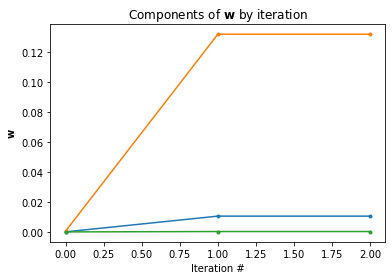

In [19]:
plt.plot(ws, ".-");
plt.xlabel("Iteration #")
plt.ylabel("$\mathbf{w}$")
plt.title("Components of $\mathbf{w}$ by iteration");

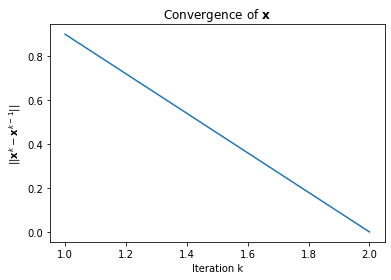

In [20]:
pd.DataFrame(xs).diff(\
                      ).abs().sum(axis = 1).iloc[1:].plot(xlabel = "Iteration k",\
                                                          ylabel = "||$\mathbf{x}^k - \mathbf{x}^{k-1}$||",\
                                                          title = "Convergence of $\mathbf{x}$");

In [21]:
print("xi for SVM as a function of iteration number")
print(pd.DataFrame(xi_svm).sum(axis = 1))
print("xi for MVO as a function of iteration number")
print(pd.DataFrame(xi_mvo).sum(axis = 1))
print("These two series should converge to the same thing")

xi for SVM as a function of iteration number
0    0.278514
1    0.000090
2    0.000090
dtype: float64
xi for MVO as a function of iteration number
0    0.000000
1    0.142717
2    0.000090
dtype: float64
These two series should converge to the same thing


In [22]:
#is there non separability
#check the last iteration xis
xi_mvo[-1][xi_mvo[-1] > 0.001]

array([], dtype=float64)

In [23]:
#what is the asset allocation for non separable xi
xs[-1][xi_mvo[-1] > 0.001]

array([], dtype=float64)

In [24]:
#which side of the hyperplane are the non separable points on. 
np.dot(Y_.values[xi_mvo[-1] > 10**(-6)], SVM_.w.x)+ SVM_.b.x

array([-0.00090952])

### Frontier generated using ADM

Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca

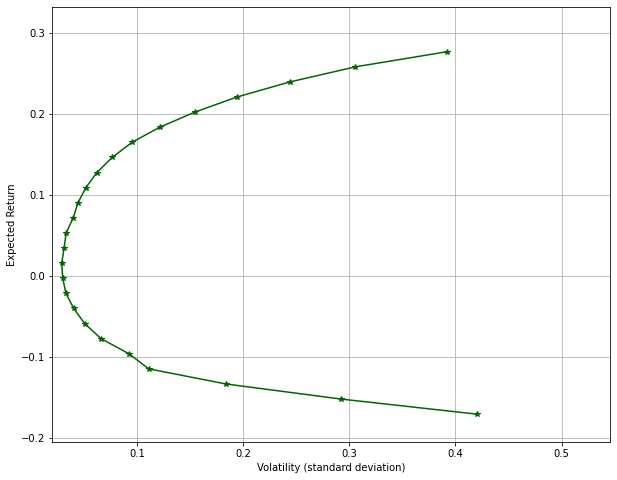

In [25]:
frontier, ws, xis = SVM_MVO_Fast.get_frontier()

##Exact MIP Solution

In [33]:
#SVM with slack 
SVM_MVO_Slck = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_, AssetLim, \
                      svm_choice = (True, True), print_var_frntr = False, indicator = True)
SVM_MVO_Slck.setModel()
SVM_MVO_Slck.model.params.Presolve = 2
SVM_MVO_Slck.model.Params.ImpliedCuts = 2
SVM_MVO_Slck.optimize()

Changed value of parameter Presolve to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter ImpliedCuts to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Optimize a model with 575 rows, 1148 columns and 2002 nonzeros
Model fingerprint: 0x7a1e6c9b
Model has 41044 quadratic objective terms
Model has 572 general constraints
Variable types: 862 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+05]
  Objective range  [7e+00, 7e+00]
  QObjective range [6e-07, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Presolve added 834 rows and 526 columns
Presolve time: 0.02s
Presolved: 1409 rows, 1674 columns, 5651 nonzeros
Presolved model has 549 SOS constraint(s)
Presolved model has 41044 quadrati

47.83900427818298

### Frontier generated via exact MIP solution

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Optimize a model with 575 rows, 1148 columns and 2002 nonzeros
Model fingerprint: 0xf1801150
Model has 41044 quadratic objective terms
Model has 572 general constraints
Variable types: 862 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+05]
  Objective range  [7e+00, 7e+00]
  QObjective range [6e-07, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 2e+02]

MIP start from previous solve did not produce a new incumbent solution

Presolve added 835 rows and 526 columns
Presolve time: 0.02s
Presolved: 1410 rows, 1674 columns, 5937 nonzeros
Presolved model has 549 SOS constraint(s)
Presolved model has 41044 quadratic objective terms
Variable types: 1125 continuous, 549 integer (549 binary)
Presolve removed 140

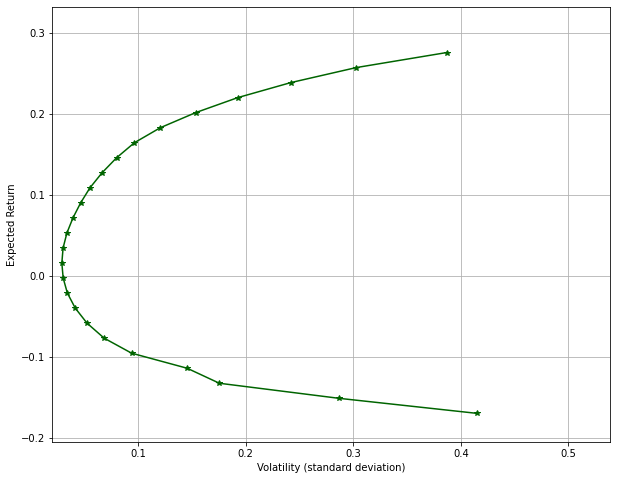

In [34]:
SVM_Slck_EF, ws, xis = SVM_MVO_Slck.get_frontier()

## Comparison between exact and ADM method

### Components of $w$

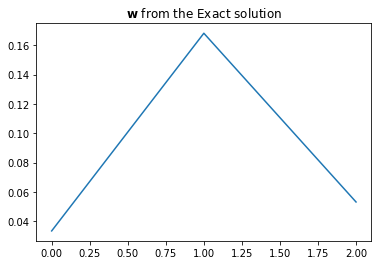

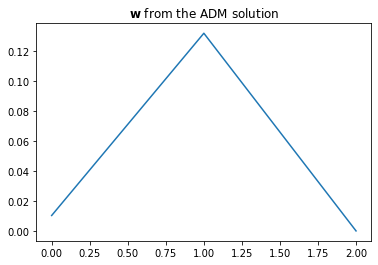

In [35]:
plt.figure(figsize = (6,4))
plt.plot(SVM_MVO_Slck.w.x)
plt.title("$\mathbf{w}$ from the Exact solution");

plt.figure(figsize = (6,4))
plt.plot(SVM_.w.x)
plt.title("$\mathbf{w}$ from the ADM solution");


In [36]:
### quick check for any mismatch between x > 0 and z = 1
MVO_.x.x[(MVO_.x.x > 10**(-6)).astype(int) - MVO_.z.x > 0]

array([], dtype=float64)

### Portfolio Comparison between exact and ADM method

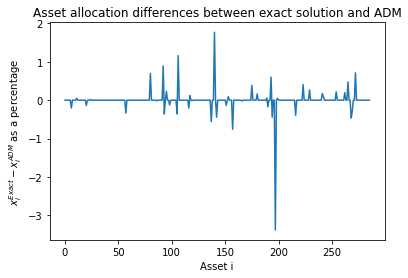

In [37]:
#plt.plot(MVO_.x.x)
plt.plot(100*(SVM_MVO_Slck.x.x - MVO_.x.x))
plt.xlabel("Asset i")
plt.ylabel("$x^{{Exact}}_i - x^{{ADM}}_i$ as a percentage");
plt.title("Asset allocation differences between exact solution and ADM");

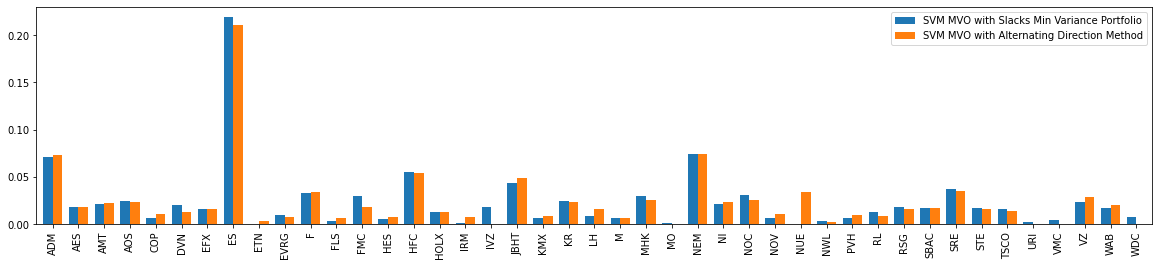

In [38]:
out = pd.concat([SVM_MVO_Slck.get_results(), SVM_MVO_Fast.get_results()], axis = 0)
out[out.columns[(out > 0.001).any(axis = 0)]].transpose()[:-2].plot.bar(figsize = (20,4), width = 0.75);

### Efficient frontiers: ADM vs. Exact Solution

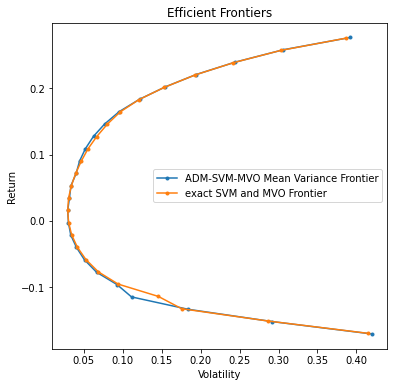

In [39]:
#Plot efficient frontiers for the SVM MVO an Vanilla MVO
plt.figure(figsize = (6,6))
plt.plot(frontier[0], frontier[1], ".-", label = "ADM-SVM-MVO Mean Variance Frontier");
plt.plot(SVM_Slck_EF[0], SVM_Slck_EF[1], ".-", label = "exact SVM and MVO Frontier");
plt.legend();
plt.ylabel('Return')
plt.xlabel('Volatility')
plt.legend()
plt.title("Efficient Frontiers");

## Cardinality Constrained MVO (quick check) - Not Important for Analysis

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Optimize a model with 289 rows, 858 columns and 1430 nonzeros
Model fingerprint: 0x10c95447
Model has 41041 quadratic objective terms
Model has 286 general constraints
Variable types: 572 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [6e-07, 6e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Presolve added 285 rows and 0 columns
Presolve removed 0 rows and 286 columns
Presolve time: 0.03s
Presolved: 574 rows, 572 columns, 1716 nonzeros
Presolved model has 41041 quadratic objective terms
Variable types: 286 continuous, 286 integer (286 binary)
Found heuristic solution: objective 0.0391937

Root relaxation: objective 6.860883e-04, 182 iteration

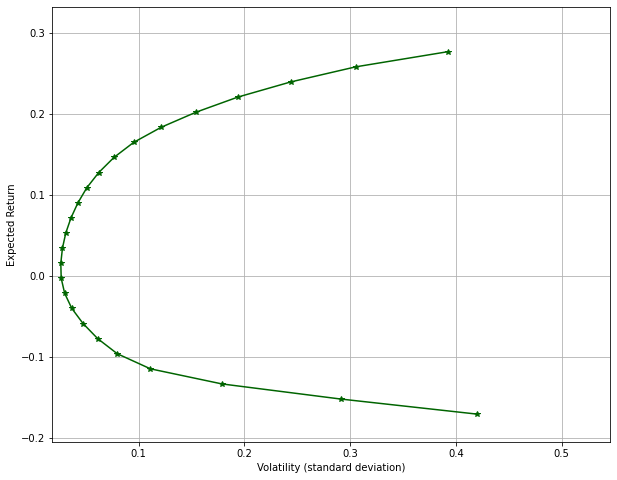

In [ ]:
MVO = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_, AssetLim,\
             svm_choice = (False, False), print_var_frntr= False,\
             indicator = False, cardinality = True) #define an instance of the class
MVO.setModel() #set up the model
MVO.optimize() #find optimal solution
MVO.model.params.OutputFlag = 0
MVO_frontier, ws, xis = MVO.get_frontier(); #ws and xi are not important here

In [ ]:
#Plot efficient frontiers for the SVM MVO an Vanilla MVO
plt.figure(figsize = (6,6))
plt.plot(frontier[0], frontier[1], ".-", label = "ADM-SVM-MVO Mean Variance Frontier");
plt.plot(SVM_Slck_EF[0], SVM_Slck_EF[1], ".-", label = "exact SVM and MVO Frontier");
plt.plot(MVO_frontier[0], MVO_frontier[1], ".-", label = "MVO Frontier");
plt.legend();
plt.ylabel('Return')
plt.xlabel('Volatility')
plt.legend()
plt.title("Efficient Frontiers");